## Stack - Projeto Human Resources Analytics

### Machine Learning.

In [1]:
import pandas as pd
import datetime
import glob
from minio import Minio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pip install pycaret

In [2]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

### Baixando o Dataset do Data Lake.

In [3]:
client.fget_object(
            "processing",
            "employees_dataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")

In [4]:
df.head()

,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


#### Organizando o dataset.

In [5]:
df = df[['department', 'salary', 'mean_work_last_3_months',
       'number_projects', 'satisfaction_level', 'last_evaluation',
       'time_in_company', 'work_accident','left']]

In [6]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0


#### Verificando os registros missing.

In [7]:
df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [8]:
df[df.notnull()]

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,0.0,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,0.0,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,0.0,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,0.0,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
14995,support,low,253.333333,2.0,37.0,48.0,3.0,0.0,1.0
14996,support,low,288.000000,2.0,37.0,53.0,3.0,0.0,1.0
14997,support,low,272.000000,6.0,11.0,96.0,4.0,0.0,1.0
14998,support,low,276.666667,2.0,37.0,52.0,3.0,0.0,1.0


In [9]:
df = df[:14998]

#### Alterando os tipos de dados.

In [10]:
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14998 entries, 0 to 14997
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   department               14998 non-null  object 
 1   salary                   14998 non-null  object 
 2   mean_work_last_3_months  14998 non-null  int32  
 3   number_projects          14998 non-null  int32  
 4   satisfaction_level       14998 non-null  float64
 5   last_evaluation          14998 non-null  float64
 6   time_in_company          14998 non-null  int32  
 7   work_accident            14998 non-null  int32  
 8   left                     14998 non-null  int32  
dtypes: float64(2), int32(5), object(2)
memory usage: 761.7+ KB


In [12]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


In [13]:
df = df[:14998]

#### Renomeando atributos

In [14]:
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

In [15]:
df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1
3,sales,low,275,5,72.0,87.0,5,0,1
4,sales,low,292,2,37.0,52.0,3,0,1


## Preprocessamento

#### Converte os atributos categoricos valores numéricos.

In [16]:
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

In [17]:
df.head()

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,7,1,266,2,38.0,53.0,3,0,1
1,7,2,252,5,80.0,86.0,6,0,1
2,7,2,289,7,11.0,88.0,4,0,1
3,7,1,275,5,72.0,87.0,5,0,1
4,7,1,292,2,37.0,52.0,3,0,1


#### Separando os conjuntos de dados.

In [18]:
target_name = 'turnover'
X = df.drop('turnover', axis=1)
y = df[target_name]

#### Transformando os dados.

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
X = scaler.fit_transform(X)

In [22]:
X

array([[0.77777778, 0.5       , 0.38202247, ..., 0.265625  , 0.125     ,
        0.        ],
       [0.77777778, 1.        , 0.2247191 , ..., 0.78125   , 0.5       ,
        0.        ],
       [0.77777778, 1.        , 0.64044944, ..., 0.8125    , 0.25      ,
        0.        ],
       ...,
       [0.88888889, 0.5       , 0.23595506, ..., 0.1875    , 0.125     ,
        0.        ],
       [0.88888889, 0.5       , 0.62921348, ..., 0.265625  , 0.125     ,
        0.        ],
       [0.88888889, 0.5       , 0.4494382 , ..., 0.9375    , 0.25      ,
        0.        ]])

### Separando os conjuntos de dados.

<img src="https://www.researchgate.net/profile/Brian-Mwandau/publication/325870973/figure/fig6/AS:639531594285060@1529487622235/Train-Test-Data-Split.png" align="left">

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

#### Treinando o algoritmo de arvore de decisão.

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)

In [27]:
importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns

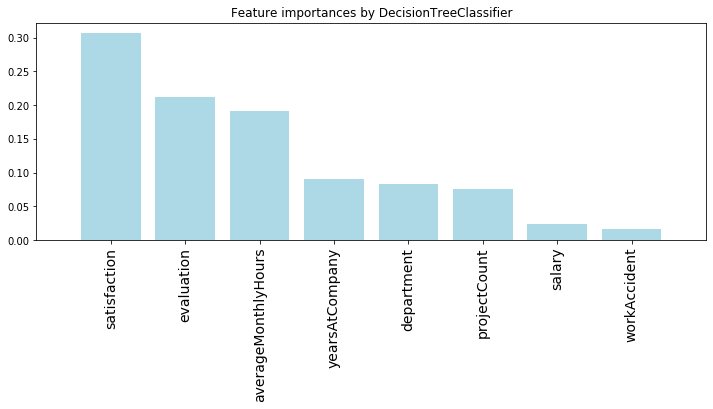

In [28]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Filtrando apenas os atributos relevantes.

In [29]:
X = df[["satisfaction","evaluation","averageMonthlyHours","yearsAtCompany"]]

#### Separando os conjuntos de dados.

In [30]:
scaler = MinMaxScaler()

In [31]:
X = scaler.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

In [33]:
X_train

array([[0.06593407, 0.046875  , 0.53932584, 0.25      ],
       [0.        , 0.703125  , 0.41573034, 0.25      ],
       [0.81318681, 0.296875  , 0.76404494, 0.625     ],
       ...,
       [0.32967033, 0.3125    , 0.59550562, 0.125     ],
       [0.83516484, 0.359375  , 0.58426966, 0.        ],
       [0.50549451, 0.578125  , 0.46067416, 0.125     ]])

#### Função do modelo de base.

In [34]:
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

#### Importando métodos de métrica de avaliação.

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [36]:
def accuracy_result(y_test,y_predict):
    acc = accuracy_score(y_test, y_predict)
    print ("Accuracy = %2.2f" % acc)

In [37]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de baseline

In [38]:
y_predict = base_rate_model(X_test)

In [39]:
accuracy_result(y_test, y_predict)

Accuracy = 0.76


In [40]:
roc_classification_report_results("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2286
           1       0.00      0.00      0.00       714

    accuracy                           0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



F:\py\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo de Regressão Logística.

<img src="https://editor.analyticsvidhya.com/uploads/95588WhatsApp-Image-2020-02-11-at-8.30.11-PM.jpeg" align="left">

#### Instânciando o algoritmo.

In [41]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression()

#### Realizando o treinamento.

In [42]:
logis.fit(X_train, y_train)

LogisticRegression()

#### Calculando as predições.

In [43]:
y_predict = logis.predict(X_test)

#### Avaliando o resultado.

In [44]:
accuracy_result(y_test, y_predict)

Accuracy = 0.75


In [45]:
roc_classification_report_results("Logistic Regression", y_test, y_predict)


Logistic Regression AUC = 0.5053008079872368

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      2286
           1       0.33      0.03      0.05       714

    accuracy                           0.75      3000
   macro avg       0.55      0.51      0.46      3000
weighted avg       0.66      0.75      0.67      3000



### Modelo de Arvore de decisão.

<img src="https://www.devops.ae/wp-content/uploads/2021/04/decision-tree-classification-algorithm.png" align="left">

#### Instânciando o algoritmo.

In [46]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [47]:
dtree = dtree.fit(X_train,y_train)

#### Calculando as predições.

In [48]:
y_predict = dtree.predict(X_test)

#### Avaliando o resultado.

In [49]:
accuracy_result(y_test, y_predict)

Accuracy = 0.72


In [50]:
roc_classification_report_results("Decision Tree", y_test, y_predict)


Decision Tree AUC = 0.6313971782938897

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2286
           1       0.42      0.46      0.44       714

    accuracy                           0.72      3000
   macro avg       0.63      0.63      0.63      3000
weighted avg       0.73      0.72      0.73      3000



### Modelo de Floresta Aleatória (Random Forest)

<img src="https://miro.medium.com/max/1200/0*YEwFetXQGPB8aDFV" align="left">

#### Instânciando o algoritmo.

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf = RandomForestClassifier()

#### Realizando o treinamento.

In [53]:
rf = rf.fit(X_train,y_train)

#### Calculando as predições.

In [54]:
y_predict = rf.predict(X_test)

#### Avaliando o resultado.

In [55]:
accuracy_result(y_test, y_predict)

Accuracy = 0.80


In [56]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.6857286221575244

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      2286
           1       0.62      0.46      0.53       714

    accuracy                           0.80      3000
   macro avg       0.73      0.69      0.70      3000
weighted avg       0.79      0.80      0.79      3000



### Pycaret

<img src="https://miro.medium.com/max/1024/0*T3u62CFmhRgur_ZZ.png" align="left">

<img src="https://i.pinimg.com/originals/28/c3/de/28c3decb69d2b89c42e3979a9565d84b.jpg" align="left">

#### Importando os métodos.

In [57]:
from pycaret.classification import *

#### Definindo o Setup.

In [58]:
s = setup( df[["satisfaction","evaluation","averageMonthlyHours","yearsAtCompany","turnover"]]
          ,target = "turnover"
          ,numeric_features = ["yearsAtCompany"]
          ,normalize = True
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
         )

,Description,Value
0,session_id,8585
1,Target,turnover
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14998, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


#### Comparando diferentes modelos.

In [59]:
best = compare_models(fold = 5,sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8103,0.7718,0.6395,0.5946,0.6161,0.4904,0.4911,0.3200
lightgbm,Light Gradient Boosting Machine,0.8204,0.7684,0.5954,0.6300,0.6122,0.4955,0.4959,0.2160
catboost,CatBoost Classifier,0.8227,0.7667,0.6027,0.6344,0.6181,0.5028,0.5031,2.1520
ada,Ada Boost Classifier,0.7872,0.7637,0.6439,0.5456,0.5902,0.4479,0.4511,0.1300
xgboost,Extreme Gradient Boosting,0.8140,0.7582,0.5510,0.6236,0.5851,0.4658,0.4673,0.3920
rf,Random Forest Classifier,0.7864,0.7460,0.4870,0.5590,0.5204,0.3839,0.3855,0.6060
qda,Quadratic Discriminant Analysis,0.7004,0.7248,0.7143,0.4233,0.5316,0.3319,0.3565,0.0200
et,Extra Trees Classifier,0.7817,0.7147,0.4794,0.5471,0.5109,0.3712,0.3726,0.5260
knn,K Neighbors Classifier,0.6877,0.7138,0.6575,0.4040,0.5004,0.2916,0.3100,0.1380
nb,Naive Bayes,0.6973,0.6963,0.5606,0.4022,0.4683,0.2646,0.2718,0.0120


#### Criando o modelo.

In [60]:
gbc = create_model('gbc', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8057,0.7697,0.6420,0.5836,0.6114,0.4823,0.4833
1,0.8157,0.7694,0.6420,0.6068,0.6239,0.5020,0.5023
2,0.8095,0.7600,0.6200,0.5962,0.6078,0.4821,0.4823
3,0.8137,0.7778,0.6533,0.5993,0.6251,0.5015,0.5023
4,0.8071,0.7823,0.6400,0.5872,0.6124,0.4843,0.4851
Mean,0.8103,0.7718,0.6395,0.5946,0.6161,0.4904,0.4911
SD,0.0038,0.0077,0.0108,0.0084,0.0070,0.0093,0.0092


#### Realizando o tunning do modelo.

In [61]:
tuned_gbc = tune_model(gbc
                      ,fold = 5
                      ,custom_grid = {
                                      "learning_rate":[0.1,0.2,0.5]
                                     ,"n_estimators":[100,500,1000]
                                     ,"min_samples_split":[1,2,5,10]
                                     ,"max_depth":[1,3,9]
                                     }
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7714,0.7551,0.6300,0.5164,0.5676,0.4143,0.4181
1,0.7867,0.7616,0.6200,0.5458,0.5805,0.4383,0.4399
2,0.7905,0.7540,0.6160,0.5540,0.5833,0.4439,0.4450
3,0.7918,0.7754,0.6493,0.5529,0.5972,0.4581,0.4608
4,0.7870,0.7822,0.6700,0.5429,0.5998,0.4569,0.4616
Mean,0.7855,0.7657,0.6371,0.5424,0.5857,0.4423,0.4451
SD,0.0073,0.0112,0.0201,0.0137,0.0118,0.0159,0.0160


In [62]:
predict_model(gbc, data=df)

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover,Label,Score
0,7,1,266,2,38.0,53.0,3,0,1,1,0.8121
1,7,2,252,5,80.0,86.0,6,0,1,1,0.5661
2,7,2,289,7,11.0,88.0,4,0,1,1,0.7748
3,7,1,275,5,72.0,87.0,5,0,1,1,0.7646
4,7,1,292,2,37.0,52.0,3,0,1,1,0.8098
...,...,...,...,...,...,...,...,...,...,...,...
14993,9,1,279,6,76.0,83.0,6,0,1,1,0.5046
14994,8,1,287,2,40.0,57.0,3,0,1,1,0.6858
14995,8,1,253,2,37.0,48.0,3,0,1,1,0.8174
14996,8,1,288,2,37.0,53.0,3,0,1,1,0.8047


#### Finalizando o modelo.

In [63]:
final_model = finalize_model(gbc)

In [64]:
save_model(final_model,'model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['yearsAtCompany'],
                                       target='turnover', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
            

#### Transferindo os arquivos para o Data Lake.

#### Modelo de Classificação.

In [65]:
client.fput_object(
    "curated",
    "model.pkl",
    "model.pkl"
)

#### Exportando o conjunto de dados para o disco.

In [66]:
df[["satisfaction","evaluation","averageMonthlyHours","yearsAtCompany","turnover"]].to_csv("dataset.csv",index=False)

In [67]:
client.fput_object(
    "curated",
    "dataset.csv",
    "dataset.csv"
)